In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
ls /kaggle/input/*/

bdd100k/  bdd100k_labels_release/  bdd100k_seg/


# Libraries

In [4]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import json
import random
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm
import pandas as pd
from PIL import Image
from glob import glob

In [5]:
os.chdir("/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train/")
labels_file = "/kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/"

# Read Image

In [7]:
def read_image(image_name):
    image_name = image_name + ".jpg"
    image = cv2.imread(image_name)  

    if image is None:
        print("Error: Image not found!")
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        plt.imshow(image)
        plt.axis("off")
        plt.show()

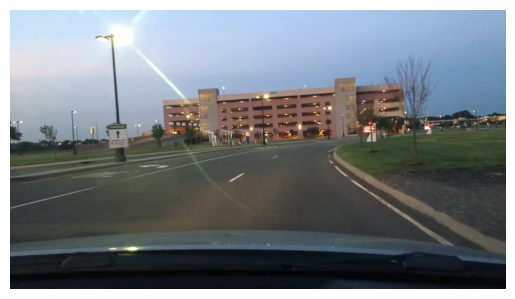

In [8]:
read_image("trainA/0000f77c-62c2a288")
# read_image("002b485a-3f6603f2")
# read_image("trainB/0001542f-5ce3cf52")


# Data Exploration

Count the occurrences of each object class in the KITTI dataset labels and visualize the distribution using a bar chart.

In [9]:
def label_counts_distribution():
    labels_file_train = labels_file + "bdd100k_labels_images_train.json"
    label_counts = Counter()

    with open(labels_file_train, "r") as file:
        data = json.load(file)
        
        for img_data in data:
            for label in img_data.get("labels", []):
                class_name = label.get("category", "unknown")
                label_counts[class_name] += 1

    return label_counts

label_distribution = label_counts_distribution()
print(label_distribution)


Counter({'car': 713211, 'lane': 528643, 'traffic sign': 239686, 'traffic light': 186117, 'drivable area': 125723, 'person': 91349, 'truck': 29971, 'bus': 11672, 'bike': 7210, 'rider': 4517, 'motor': 3002, 'train': 136})


Distribution
traffic light: 186117
traffic sign: 239686
car: 713211
drivable area: 125723
lane: 528643
person: 91349
bus: 11672
truck: 29971
rider: 4517
bike: 7210
motor: 3002
train: 136


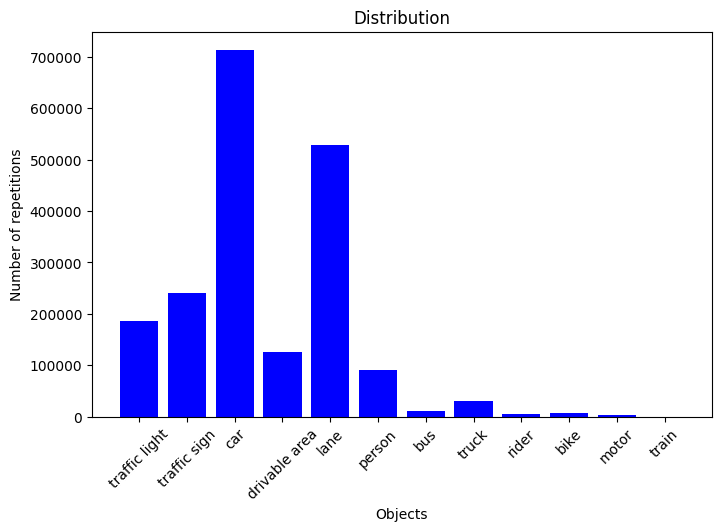

In [10]:
label_counts = label_counts_distribution()

print("Distribution")
for label, count in label_counts.items():
    print(f"{label}: {count}")

plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='blue')
plt.xlabel("Objects")
plt.ylabel("Number of repetitions")
plt.title("Distribution")
plt.xticks(rotation=45)
plt.show()

## Data Quality Analysis

### Image Resolution

In [11]:
def image_resolutions(image_dir):
    resolutions = []

    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        
        img = cv2.imread(image_path)
        if img is not None:
            height, width = img.shape[:2]
            resolutions.append((height, width))

    return np.array(resolutions)



In [12]:
image_dir = "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train"
resolutions = image_resolutions(image_dir)

unique_resolutions = np.unique(resolutions, axis=0)
print("Unique Image Resolutions:", unique_resolutions)



Unique Image Resolutions: [[ 720 1280]]


### Bounding Box

This method reads a label file, extracts bounding box coordinates for detected objects, and retrieves environmental tags (e.g., weather, lighting) along with the road type. It returns a list of bounding boxes, environment tags, and the road type.

In [13]:
def extract_bounding_boxes_and_tags(imageName):
    # bounding_boxes = [] 
    # environment_tags = []
    # road_type = ""
    label_file_path= "/kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json"

    # label_path = f"{labels_dir}{imageName}.txt"
    # label_path = f"{labels_dir}{imageName}.jpg"
    # if os.path.exists(label_path):
    #     with open(label_path, "r") as file:
    #         for line in file:
    #             values = line.split()
    #             if values[0] != 'DontCare':
    #                 x_min, y_min, x_max, y_max = map(float, values[4:8])
    #                 bounding_boxes.append((x_min, y_min, x_max, y_max))
    #                 environment_tags = values[-4:-1] 
    #                 road_type = values[-1] 
    # else:
    #     print(f"Not Found: {label_path}")
  
    bounding_boxes = []
    categories = []
    environment_tags = []
    road_type = ""
    if os.path.exists(label_file_path):
        with open(label_file_path, 'r') as f:
            data = json.load(f)  # This is a list

        # Search for image entry by name
        target_name = imageName + ".jpg"
        for item in data:
            if item.get("name") == target_name:
                # Extract labels
                for label in item.get("labels", []):
                    if "box2d" in label:
                        box = label["box2d"]
                        x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]
                        bounding_boxes.append((x1, y1, x2, y2))
                        categories.append(label.get("category", "unknown"))

                # Extract environment info
                attr = item.get("attributes", {})
                environment_tags = [
                    attr.get("weather", ""),
                    attr.get("scene", ""),
                    attr.get("timeofday", "")
                ]
                road_type = attr.get("scene", "")  # assuming "scene" is road type
                break
    else:
        print(f"File not found: {label_file_path}")

    return bounding_boxes, categories, environment_tags, road_type

    # return bounding_boxes, environment_tags, road_type

In [14]:
boxes, tags, env_tags, road = extract_bounding_boxes_and_tags("0000f77c-62c2a288")

for box, tag  in zip(boxes, tags):
    print(f"{tag}: {box}")
    print("Environment tags:", env_tags)
    print("Road type:", road)



traffic sign: (250.549246, 294.619798, 308.085801, 357.05308)
Environment tags: ['clear', 'highway', 'dawn/dusk']
Road type: highway
traffic sign: (206.478694, 299.516526, 221.16888, 321.551802)
Environment tags: ['clear', 'highway', 'dawn/dusk']
Road type: highway
traffic sign: (924.665474, 286.866651, 936.907294, 297.884289)
Environment tags: ['clear', 'highway', 'dawn/dusk']
Road type: highway
person: (423.158909, 336.241987, 434.176547, 358.277263)
Environment tags: ['clear', 'highway', 'dawn/dusk']
Road type: highway
person: (563.939839, 324.000165, 573.733294, 348.483804)
Environment tags: ['clear', 'highway', 'dawn/dusk']
Road type: highway
person: (656.977672, 315.838956, 666.771127, 345.219323)
Environment tags: ['clear', 'highway', 'dawn/dusk']
Road type: highway


### Detect Biases

function extracts the center coordinates (x_center, y_center) of bounding boxes from label files in labels_dir, grouping them by object class in a dictionary. 
It returns a dictionary where keys are object classes and values are lists of center positions.

In [15]:
def detect_box_positions_from_json():
    json_path= "/kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json"

    bbox_positions = {}

    with open(json_path, "r") as file:
        data = json.load(file)

    # `data` is a list of image objects
    for image_obj in data:
        labels = image_obj.get("labels", [])
        
        for label in labels:
            if "box2d" in label:
                class_id = label.get("category", "Unknown")
                box = label["box2d"]
                x1, y1 = box["x1"], box["y1"]
                x2, y2 = box["x2"], box["y2"]
                
                x_center = (x1 + x2) / 2
                y_center = (y1 + y2) / 2

                if class_id not in bbox_positions:
                    bbox_positions[class_id] = []

                bbox_positions[class_id].append((x_center, y_center))

    return bbox_positions


In [16]:
# bbox_positions = detect_box_positions()
# plt.figure(figsize=(10, 6))

# colors = ['red', 'blue', 'green', 'purple', 'orange']
# for i, (class_id, positions) in enumerate(bbox_positions.items()):
#     positions = np.array(positions)
#     plt.scatter(positions[:, 0], positions[:, 1], alpha=0.5, s=10, color=colors[i % len(colors)], label=f"Class {class_id}")

# plt.xlabel("X Center")
# plt.ylabel("Y Center")
# plt.title("Bounding Boxes")
# plt.gca().invert_yaxis()
# plt.legend()
# plt.show()
positions = detect_box_positions_from_json()

for class_id, centers in positions.items():
    print(f"{class_id}: Found {len(centers)} centers")



traffic light: Found 186117 centers
traffic sign: Found 239686 centers
car: Found 713211 centers
person: Found 91349 centers
bus: Found 11672 centers
truck: Found 29971 centers
rider: Found 4517 centers
bike: Found 7210 centers
motor: Found 3002 centers
train: Found 136 centers


In [17]:
# if not (0 <= x_center <= 1) or not (0 <= y_center <= 1):
#     print(f"Warning: Invalid coordinates ({x_center}, {y_center}) in file {label_file}")


In [18]:

# bbox_positions = [pos for pos in bbox_positions if 0 <= pos[0] <= 1 and 0 <= pos[1] <= 1]
# bbox_positions

Weather distribution:
  clear: 37344
  rainy: 5070
  undefined: 8119
  snowy: 5549
  overcast: 8770
  partly cloudy: 4881
  foggy: 130

Time of Day distribution:
  daytime: 36728
  dawn/dusk: 5027
  night: 27971
  undefined: 137

Scene Type distribution:
  city street: 43516
  highway: 17379
  residential: 8074
  parking lot: 377
  undefined: 361
  tunnel: 129
  gas stations: 27


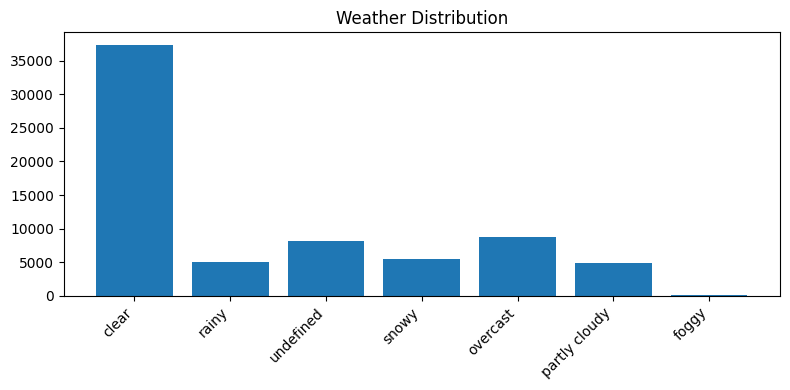

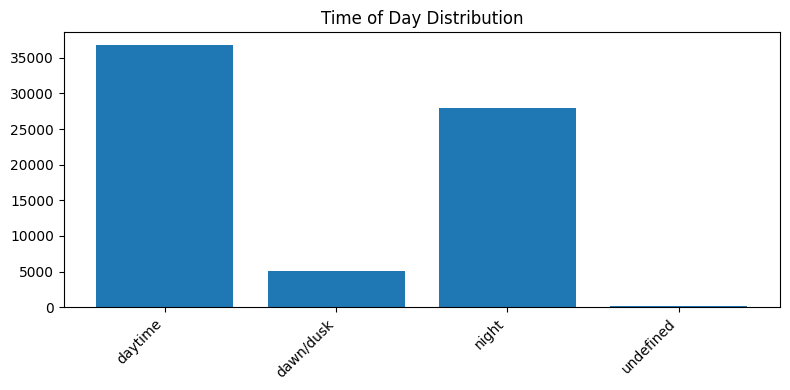

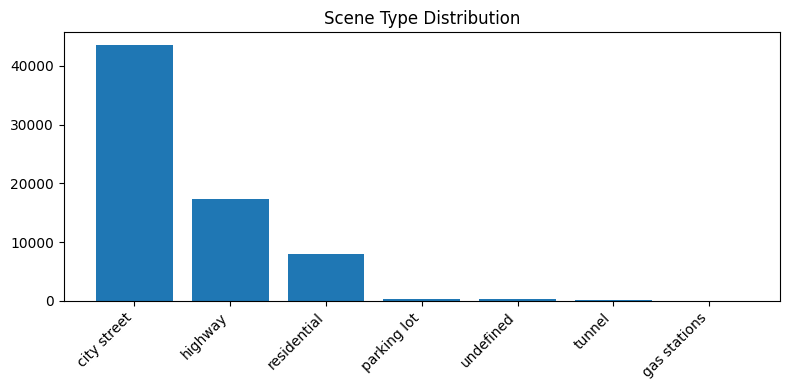

In [19]:
labels_file = "/kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/"
labels_json = os.path.join(labels_file, "bdd100k_labels_images_train.json")

def env_distribution(labels_json_path):
    weather_counts   = Counter()
    timeofday_counts = Counter()
    scene_counts     = Counter()

    with open(labels_json_path, 'r') as f:
        data = json.load(f)

    for img in data:
        attr = img.get("attributes", {})
        weather_counts[attr.get("weather",   "unknown")] += 1
        timeofday_counts[attr.get("timeofday","unknown")] += 1
        scene_counts[attr.get("scene",       "unknown")] += 1

    return weather_counts, timeofday_counts, scene_counts


weather_counts, time_counts, scene_counts = env_distribution(labels_json)


print("Weather distribution:")
for k, v in weather_counts.items():
    print(f"  {k}: {v}")
print("\nTime of Day distribution:")
for k, v in time_counts.items():
    print(f"  {k}: {v}")
print("\nScene Type distribution:")
for k, v in scene_counts.items():
    print(f"  {k}: {v}")


def plot_dist(counter, title):
    plt.figure(figsize=(8, 4))
    plt.bar(counter.keys(), counter.values())
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_dist(weather_counts,   "Weather Distribution")
plot_dist(time_counts,      "Time of Day Distribution")
plot_dist(scene_counts,     "Scene Type Distribution")

Underrepresented environmental categories (count < 5% of total):
  Weather: ['foggy']
  Time of Day: ['undefined']
  Scene: ['parking lot', 'undefined', 'tunnel', 'gas stations']


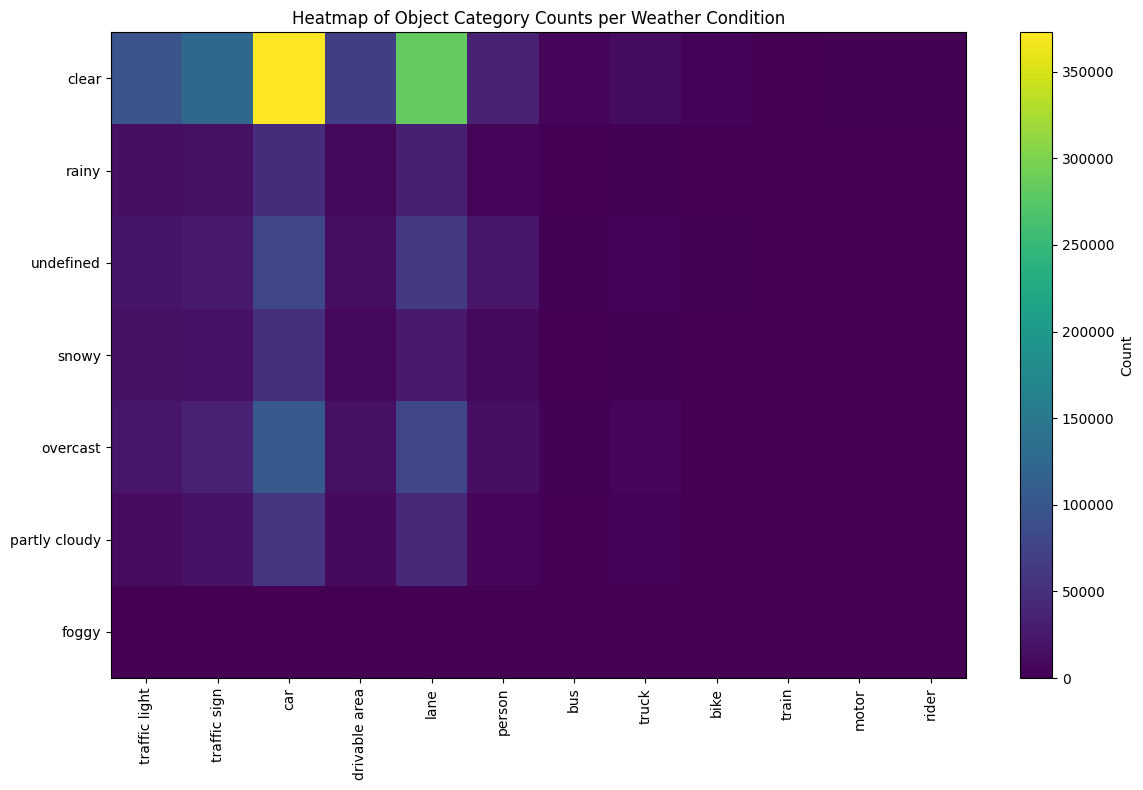

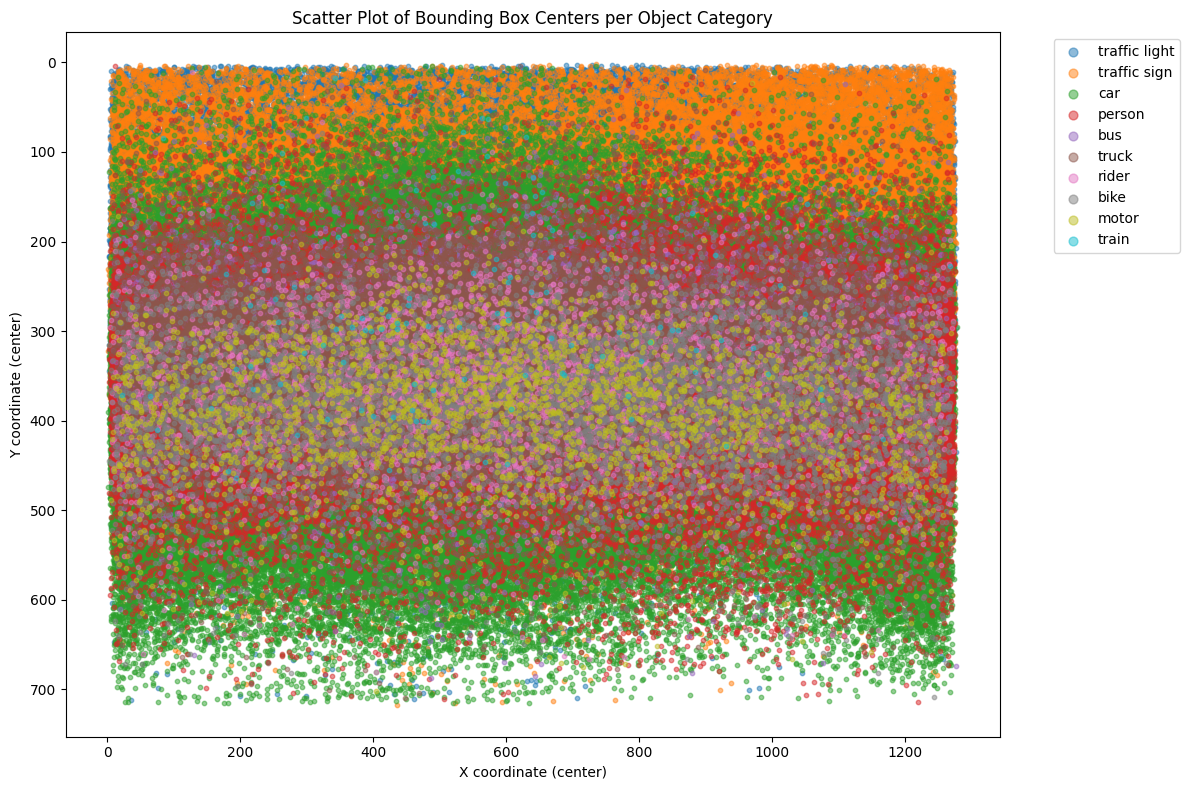

No invalid boxes or labels were detected.


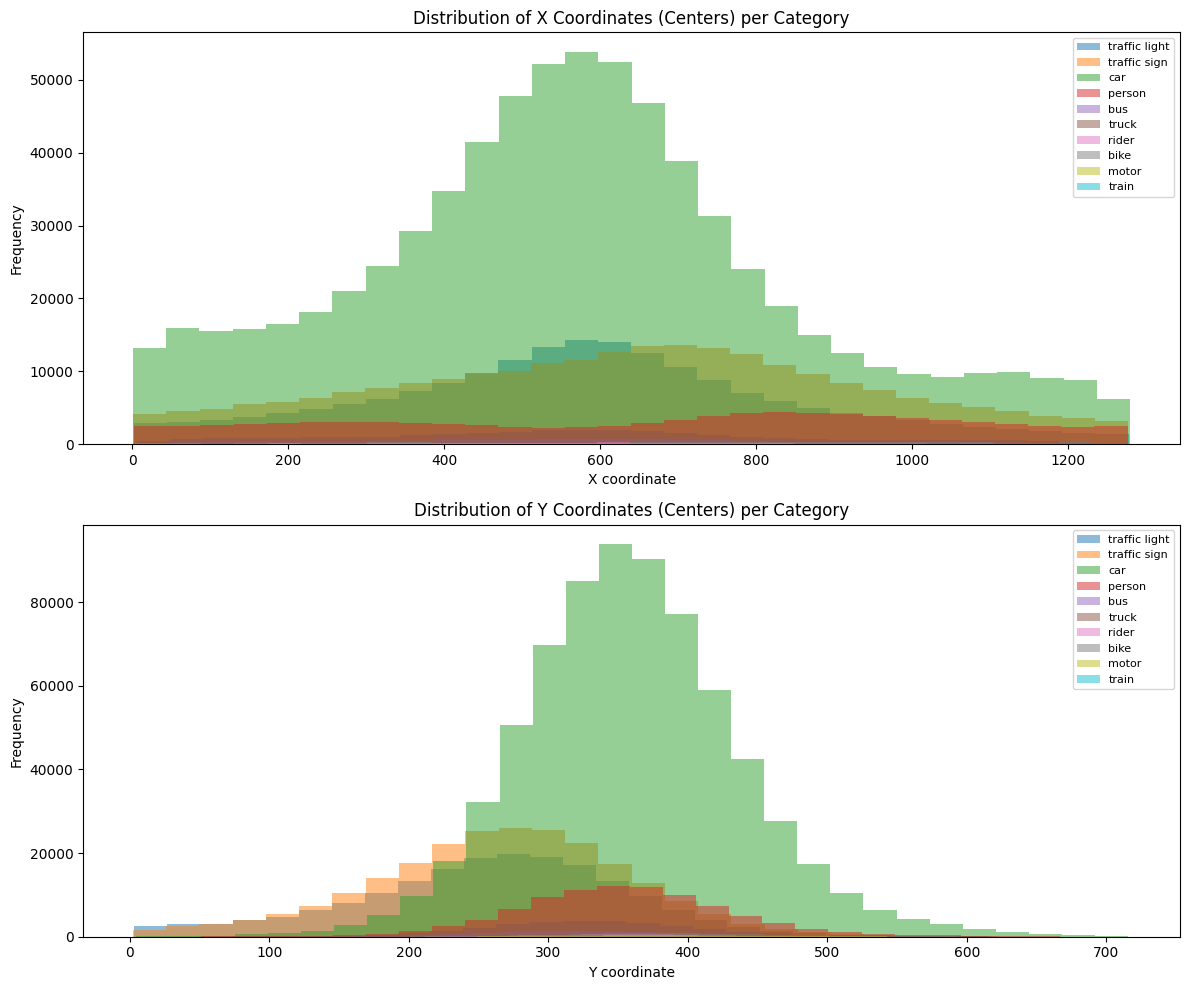

In [20]:
with open(labels_json, 'r') as f:
    data = json.load(f)

# Count occurrences of environmental attributes
weather_counts = Counter()
timeofday_counts = Counter()
scene_counts = Counter()

for img in data:
    attr = img.get("attributes", {})
    weather_counts[attr.get("weather", "unknown")] += 1
    timeofday_counts[attr.get("timeofday", "unknown")] += 1
    scene_counts[attr.get("scene", "unknown")] += 1

total_images = len(data)
threshold = 0.05 * total_images
print("Underrepresented environmental categories (count < 5% of total):")
for name, cnt in [("Weather", weather_counts),
                  ("Time of Day", timeofday_counts),
                  ("Scene", scene_counts)]:
    under = [k for k, v in cnt.items() if v < threshold]
    print(f"  {name}: {under}")

# Build a contingency table (weather × object category)
weather_cat = {}
for img in data:
    w = img.get("attributes", {}).get("weather", "unknown")
    weather_cat.setdefault(w, Counter())
    for label in img.get("labels", []):
        cat = label.get("category", "unknown")
        weather_cat[w][cat] += 1

# Convert to DataFrame
df_weather_cat = pd.DataFrame(weather_cat).T.fillna(0).astype(int)

# Plot heatmap using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(df_weather_cat.values, aspect='auto', cmap="viridis")
plt.colorbar(label="Count")
plt.xticks(np.arange(len(df_weather_cat.columns)), df_weather_cat.columns, rotation=90)
plt.yticks(np.arange(len(df_weather_cat.index)), df_weather_cat.index)
plt.title("Heatmap of Object Category Counts per Weather Condition")
plt.tight_layout()
plt.show()

# Define image dimensions (assumed resolution)
IMG_WIDTH = 1280
IMG_HEIGHT = 720

def extract_boxes_and_centers(data):
    """
    Extracts bounding boxes and calculates their centers for each object.
    Returns a dictionary mapping each category to a list of center coordinates,
    as well as a list of any invalid bounding boxes.
    """
    centers_by_class = {}
    invalid_boxes = []
    for img in data:
        for label in img.get("labels", []):
            cat = label.get("category", "unknown")
            if "box2d" in label:
                box = label["box2d"]
                x1, y1 = box.get("x1"), box.get("y1")
                x2, y2 = box.get("x2"), box.get("y2")
                if x1 is None or y1 is None or x2 is None or y2 is None:
                    invalid_boxes.append((cat, box, "Missing coordinate"))
                    continue
                if not (0 <= x1 < x2 <= IMG_WIDTH and 0 <= y1 < y2 <= IMG_HEIGHT):
                    invalid_boxes.append((cat, box, "Coordinates out of range or invalid order"))
                    continue
                x_center = (x1 + x2) / 2
                y_center = (y1 + y2) / 2
                centers_by_class.setdefault(cat, []).append((x_center, y_center))
    return centers_by_class, invalid_boxes

centers_by_class, invalid_boxes = extract_boxes_and_centers(data)

# Scatter plot for bounding box centers per object category

plt.figure(figsize=(12, 8))
# Use the updated method to obtain a colormap
cmap = plt.colormaps['tab10']
# Generate a list of colors using a linear spacing between 0 and 1 based on the number of categories
colors = [cmap(i) for i in np.linspace(0, 1, len(centers_by_class))]
for color, (cat, centers) in zip(colors, centers_by_class.items()):
    centers_np = np.array(centers)
    if centers_np.size == 0:
        continue
    plt.scatter(centers_np[:, 0], centers_np[:, 1], alpha=0.5, s=10, color=color, label=cat)

plt.xlabel("X coordinate (center)")
plt.ylabel("Y coordinate (center)")
plt.title("Scatter Plot of Bounding Box Centers per Object Category")
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinate system (origin at the top)
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Display invalid bounding boxes, if any
if invalid_boxes:
    print("Some invalid or erroneous labels were detected:")
    for cat, box, reason in invalid_boxes[:10]:
        print(f"Category: {cat}, Box: {box}, Reason: {reason}")
else:
    print("No invalid boxes or labels were detected.")



def plot_center_distributions(centers_by_class):
    """
    Plots histograms to analyze the distribution of bounding box centers (X and Y coordinates) per category.
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    for cat, centers in centers_by_class.items():
        centers_np = np.array(centers)
        if centers_np.size == 0:
            continue
        # Histogram for X coordinate distribution
        axes[0].hist(centers_np[:, 0], bins=30, alpha=0.5, label=cat)
        # Histogram for Y coordinate distribution
        axes[1].hist(centers_np[:, 1], bins=30, alpha=0.5, label=cat)
    axes[0].set_title("Distribution of X Coordinates (Centers) per Category")
    axes[0].set_xlabel("X coordinate")
    axes[0].set_ylabel("Frequency")
    axes[0].legend(fontsize=8)
    axes[1].set_title("Distribution of Y Coordinates (Centers) per Category")
    axes[1].set_xlabel("Y coordinate")
    axes[1].set_ylabel("Frequency")
    axes[1].legend(fontsize=8)
    plt.tight_layout()
    plt.show()

plot_center_distributions(centers_by_class)


# Preprocessing for datasets

## YOLO Format :
* \<object-class\>  \<x_center\>  \<y_center\>  \<width\>  \<height\>

##  Dataset Format Handling

* BDD100K: JSON files in COCO-like format.


## Bounding Box Location Guide
* (x1, y1) = Top-left corner of the box

* (x2, y2) = Bottom-right corner

## BDD100K Preprocessing Steps:
* Parse the JSON annotation files.

* Extract category, bounding boxes.

* Convert to YOLO format.

* Map categories to class IDs (you may need to create a consistent class list across both datasets).

* Save images and corresponding YOLO .txt files.

In [6]:
!mkdir -p /kaggle/working/custom_Dataset/trainingData/labels/train \
         /kaggle/working/custom_Dataset/trainingData/labels/val \
         /kaggle/working/custom_Dataset/trainingData/images/train \
         /kaggle/working/custom_Dataset/trainingData/images/val


## Extract Labels from JSON and convert it to Yolo form

In [7]:
json_path = "/kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json"

with open(json_path, "r") as f:
    data = json.load(f)

# Extract all unique category labels
categories = set()

for item in data:
    for label in item.get("labels", []):
        if "category" in label:
            categories.add(label["category"])

print(sorted(categories))


['bike', 'bus', 'car', 'drivable area', 'lane', 'motor', 'person', 'rider', 'traffic light', 'traffic sign', 'train', 'truck']


In [8]:
training_image_folders = [
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train/",
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train/trainA/",
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train/trainB/",
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/test/trainA/",
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/test/trainB/",
]



testing_image_folders = [
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train/testA/",
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train/testB/",
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/test/"
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/test/testA/",
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/test/testB/",
]

validating_image_folders = [
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/val/"
]

## For training set

In [ ]:

json_path = "/kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json"
image_dir = "/kaggle/input/solesensei_bdd100k/bdd100k_images/bdd100k/images/100k/train"
output_label_dir = "/kaggle/working/custom_Dataset/trainingData/labels/train"
output_image_dir = "/kaggle/working/custom_Dataset/trainingData/images/train"

# Label map
label_map = {
    "bike": 0,
    "bus": 1,
    "car": 2,
    "drivable area": 3,
    "lane": 4,
    "motor": 5,
    "person": 6,
    "rider": 7,
    "traffic light": 8,
    "traffic sign": 9,
    "train": 10,
    "truck": 11
}

# Load JSON
with open(json_path, "r") as f:
    data = json.load(f)

# Create output directories if not exist
os.makedirs(output_label_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)

# Process each image
for image_info in data:
    image_name = image_info["name"]
    labels = image_info['labels']
    # Find the image path in one of the image folders
    for folder in training_image_folders:
        temp_image_path = os.path.join(folder, image_name)
        if os.path.exists(temp_image_path):
            image_path = temp_image_path
            break

    if image_path is None:
        print(f"Image path not found for {image_name}. Skipping...")
        continue
    
    # Open image to get actual dimensions
    with Image.open(image_path) as img:
        image_width, image_height = img.size
    
    
    # Create label file name
    label_file_name = os.path.splitext(image_name)[0] + ".txt"
    # Open label file for writing
    with open(os.path.join(output_label_dir, label_file_name), "w") as label_file:
        for label in labels:
            category = label['category']
        
            # Get the class ID based on your label map
            if category in label_map:
                class_id = label_map[category]
            else:
                continue
            box2d = label.get("box2d")
            if box2d is None:
                continue  # Skip labels without box2d info

            x_center = (box2d["x1"] + box2d["x2"]) / (2 * image_width)
            y_center = (box2d["y1"] + box2d["y2"]) / (2 * image_height)
            width = (box2d["x2"] - box2d["x1"]) / image_width
            height = (box2d["y2"] - box2d["y1"]) / image_height
            
            # Write label to file
            label_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")


In [ ]:

len(os.listdir(output_label_dir))

## For validating set

In [ ]:

json_path = "/kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json"
image_dir = "/kaggle/input/solesensei_bdd100k/bdd100k_images/bdd100k/images/100k/val"
output_label_dir = "/kaggle/working/custom_Dataset/trainingData/labels/val"
output_image_dir = "/kaggle/working/custom_Dataset/trainingData/images/val"

# Label map
label_map = {
    "bike": 0,
    "bus": 1,
    "car": 2,
    "drivable area": 3,
    "lane": 4,
    "motor": 5,
    "person": 6,
    "rider": 7,
    "traffic light": 8,
    "traffic sign": 9,
    "train": 10,
    "truck": 11
}

# Load JSON
with open(json_path, "r") as f:
    data = json.load(f)

# Create output directories if not exist
os.makedirs(output_label_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)

# Process each image
for image_info in data:
    image_name = image_info["name"]
    labels = image_info['labels']
    # Find the image path in one of the image folders
    for folder in validating_image_folders:
        temp_image_path = os.path.join(folder, image_name)
        if os.path.exists(temp_image_path):
            image_path = temp_image_path
            break

    if image_path is None:
        print(f"Image path not found for {image_name}. Skipping...")
        continue
    
    # Open image to get actual dimensions
    with Image.open(image_path) as img:
        image_width, image_height = img.size
    
    
    # Create label file name
    label_file_name = os.path.splitext(image_name)[0] + ".txt"
    # Open label file for writing
    with open(os.path.join(output_label_dir, label_file_name), "w") as label_file:
        for label in labels:
            category = label['category']
        
            # Get the class ID based on your label map
            if category in label_map:
                class_id = label_map[category]
            else:
                continue
            box2d = label.get("box2d")
            if box2d is None:
                continue  # Skip labels without box2d info

            x_center = (box2d["x1"] + box2d["x2"]) / (2 * image_width)
            y_center = (box2d["y1"] + box2d["y2"]) / (2 * image_height)
            width = (box2d["x2"] - box2d["x1"]) / image_width
            height = (box2d["y2"] - box2d["y1"]) / image_height
            
            # Write label to file
            label_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")


In [ ]:
len(os.listdir(output_label_dir))

In [ ]:


# Destination folder
dest_folder = "/kaggle/working/custom_Dataset/trainingData/images/train"
os.makedirs(dest_folder, exist_ok=True)

# All source folders
training_image_folders = [
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train/",
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train/trainA/",
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train/trainB/",
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/test/trainA/",
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/test/trainB/",
]

# Supported formats
img_formats = ("*.jpg", "*.jpeg", "*.png")

# Copy images
for folder in training_image_folders:
    for ext in img_formats:
        for img_path in glob(os.path.join(folder, ext)):
            filename = os.path.basename(img_path)
            dest_path = os.path.join(dest_folder, filename)
            if not os.path.exists(dest_path):  # avoid overwriting
                shutil.copy(img_path, dest_path)

print(f"All training images copied to: {dest_folder}")


In [ ]:
# Destination folder for validation images
val_dest_folder = "/kaggle/working/custom_Dataset/trainingData/images/val"
os.makedirs(val_dest_folder, exist_ok=True)

# Validation image source folders
validating_image_folders = [
    "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/val/"
]

# Supported image formats
img_formats = ("*.jpg", "*.jpeg", "*.png")

# Copy validation images
for folder in validating_image_folders:
    for ext in img_formats:
        for img_path in glob(os.path.join(folder, ext)):
            filename = os.path.basename(img_path)
            dest_path = os.path.join(val_dest_folder, filename)
            if not os.path.exists(dest_path):  # avoid overwriting
                shutil.copy(img_path, dest_path)

print(f"All validation images copied to: {val_dest_folder}")


## Creating data.yaml file for YOLO
* This file specifies where your training and validation images and labels are stored, the number of classes, and their names.

In [ ]:
# the data.yaml content
data_yaml_content = """
train: /kaggle/working/custom_Dataset/trainingData/images/train
val: /kaggle/working/custom_Dataset/trainingData/images/val

nc: 12
names: ['bike', 'bus', 'car', 'drivable area', 'lane', 'motor', 'person', 'rider', 'traffic light', 'traffic sign', 'train', 'truck']
"""

# Path to save the data.yaml file
data_yaml_path = '/kaggle/working/custom_Dataset/data.yaml'

# Write the content to the file
with open(data_yaml_path, 'w') as file:
    file.write(data_yaml_content)

print(f"data.yaml created at {data_yaml_path}")


## Start YOLO Training

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 16.7 MB/s eta 0:00:00a 0:00:01


In [2]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 72.2MB/s]


In [ ]:

model.train(
    data="/kaggle/working/custom_Dataset/data.yaml",
    epochs=5,
    imgsz=416,  # 640 big so it takes a lot of time
    project="/kaggle/working",       
    name="first_yolo_model",         
    exist_ok=True                   
)




In [ ]:
metrics = model.val(data=data_yaml_path, imgsz=416)

In [ ]:
# Print a performance report
print("\n Model Evaluation Report")
print("="*30)
print(f"Precision      : {metrics.box.precision:.4f}")
print(f"Recall         : {metrics.box.recall:.4f}")
print(f"mAP@0.5        : {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95   : {metrics.box.map:.4f}")
print(f"Number of Classes : {len(metrics.names)}")
print(f"Speed (inference): {metrics.speed['inference']:.2f} ms/image")
print(f"Speed (NMS)       : {metrics.speed['nms']:.2f} ms/image")

# Print per-class metrics
print("\n Per-Class Report")
print("-"*30)
for i, name in metrics.names.items():
    print(f"Class {i} ({name}):")
    print(f"  Precision: {metrics.box.p[i]:.4f}")
    print(f"  Recall   : {metrics.box.r[i]:.4f}")
    print(f"  mAP@0.5  : {metrics.box.ap50[i]:.4f}")
    print(f"  mAP@0.5:0.95: {metrics.box.ap[i]:.4f}")
    print()

In [ ]:
model.save("first_yolo_model.pt")